### Lanczos Method

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time
from ipywidgets import interact, FloatSlider, IntSlider,Play

In [2]:
def createBasis(N):
    return np.array(range(2**N))

def spin_x(state,index):
    return state ^ (1<<index)

def spin_z(state,index):
    return 1 if (state & (1<<index)) != 0 else -1

def spin_z_z1_open(state,N):
    spins = np.array([1 if (state & (1<<index)) != 0 else -1 for index in range(N)])[::-1]
    return sum(np.multiply(spins[:-1],spins[1:]))

def hamiltonian_openBoundry(J = 1,g = 0.5,N = 3):
    
    states = createBasis(N)
    
    H = sp.sparse.lil_matrix((2**N,2**N))

    for state in states:
        
        H[state,state] = -J*spin_z_z1_open(state,N)
        
        sx = [spin_x(state,s) for s in range(N)]
        for i in sx:
            H[state,i] = -g
    return H

def krylovSpace(H,N,L = 20,phi = None,return_basis = False):

    norm = lambda x: np.sqrt(np.sum(np.square(x)))
    
    #L should not be more than basis size
    L = min(2**N,L)
    
    #Generating a Random Normalised Vector - psi will be our Krylov Space
    if(phi is None):
        phi = np.array([np.random.uniform(size = 2**N)])
    #psi = np.array(np.ones(2**N))
    phi = [phi.T/norm(phi)]
    
    #List of Diagonal and Off-diagonal terms
    diag,offdiag = [0],[0]

    #First Iteration
    
    phi.append(H@phi[0]) #Applying Hamiltonian
    
    diag.append(phi[0].T@phi[1]) #Finding Diagonal Term
    
    phi[1] -= diag[1]*phi[0] #New vector must be Orthogonal
    # offdiag.append(norm(psi[1])) #Offdiagonal term is the Norm of the next Vector
    
    for i in range(2,L+1):
        
        offdiag.append(norm(phi[i-1])) #Offdiagonal term is the Norm of the current Vector
        assert offdiag[i-1] != 0 ,"Offdiagonal term is zero"
        phi[i-1] /= offdiag[i-1] #Normalising the Orthogonal Vector
        
        phi.append(H@phi[i-1]) #New vector which is orthogonal but not normal

        diag.append(phi[i-1].T @ phi[i]) 

        phi[i] = phi[i] - diag[i-1]*phi[i-1] - offdiag[i-2]*phi[i-2] 

        phi[i] /= norm(phi[i])

    diag = np.array(diag[1:]).flatten()
    offdiag = offdiag[1:]
    
    #print(diag)
    if(return_basis):
        return sp.sparse.diags([offdiag,diag,offdiag],offsets = [-1,0,1]),diag, offdiag, phi[:-1]
    return sp.sparse.diags([offdiag,diag,offdiag],offsets = [-1,0,1]),diag, offdiag

"""
phi next = h*phi_prev - prev diag * phi_prev - prev_offdiag*phi_prevprev
diag = phi_prev*H*phi_prev
offdiag = norm of complete phi
""";

def e0_infinite(J, g, npts=20000):
    
    U = lambda k,J,g: np.sqrt((J-g)**2 + 4*J*g*np.sin(k/2)**2)
    return sp.integrate.quad(U,-np.pi,np.pi,args = (J,g))[0]/(-2*np.pi)

### Ground State

In [3]:
J,g,N,L = 1,1,11,20

start = time.time()
H = hamiltonian_openBoundry(J,g,N)
t1 = time.time()
Hk,diag,offdiag = krylovSpace(H,N,L)
t2 = time.time()

t2 = t2 - t1
t1 = t1 - start

Hk.asformat("array"),Hk.shape;

gs,gs_vec = sp.sparse.linalg.eigsh(H,k = 1,which="SA")
#gsk = sp.linalg.eigvalsh_tridiagonal(diag,offdiag)
gsk,gsk_vec = sp.linalg.eigh_tridiagonal(diag,offdiag)
gs = gs/N
gsk = gsk/N

data = {
    "J" : J,
    "g" : g,
    "N" : N,
    "L" : L,
    "Lanczos GSE": f'{min(gsk):.3f} ; {t2:.3f} sec' ,
    "Regular GSE": f'{gs[0]:.3f} ; {t1:.3f} sec',
    "Integral GSE": f'{e0_infinite(J,g):.3f}',
    "Error": f'{(abs(gs-min(gsk))[0]) :.3f}',
    "Error %": f'{(abs(gs-min(gsk))*100/abs(gs))[0]:.2f} %',
    "Time Gain(s)": f'{(t1-t2):.4f} sec'
}
print(*[f'{k} = {v}' for k,v in data.items()],sep = "\n")

J = 1
g = 1
N = 11
L = 20
Lanczos GSE = -1.079 ; 0.029 sec
Regular GSE = -1.241 ; 0.709 sec
Integral GSE = -1.273
Error = 0.162
Error % = 13.08 %
Time Gain(s) = 0.6801 sec


#### Variation with L

In [4]:
J,g,N,L = 10,2,12,20

H = hamiltonian_openBoundry(J,g,N)

Hk,diag,offdiag = krylovSpace(H,N,L)

gs,gs_vec = sp.sparse.linalg.eigsh(H,k = 1,which="SA")
gsk = [min(sp.linalg.eigvalsh_tridiagonal(diag[:l],offdiag[:l-1]))/N for l in range(2,L)]
gs = gs/N

data = {
    "J" : J,
    "g" : g,
    "N" : N,
    "L" : L,
    "Regular GSE": f'{gs[0]:.3f}',
    "Lanczos GSE": f'{gsk[-1]:.3f}',
    "Error": f'{(abs(gs-gsk[-1])[0]) :.3f}',
    "Error %": f'{(abs(gs-gsk[-1])*100/abs(gs))[0]:.2f} %',
}
print(f"At L = {L}",*[f'{k} = {v}' for k,v in data.items()],sep = "\n")

errors = np.abs(np.array(gsk) - gs)

At L = 20
J = 10
g = 2
N = 12
L = 20
Regular GSE = -9.284
Lanczos GSE = -9.000
Error = 0.284
Error % = 3.06 %


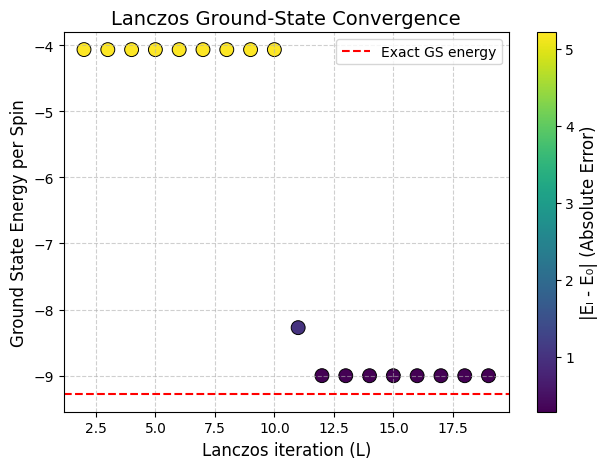

In [5]:
ls = np.arange(2,L)
plt.figure()
sc = plt.scatter(ls, gsk, c=errors, cmap='viridis', s=100, edgecolors='k', linewidth=0.7)
plt.axhline(gs[0], color='r', linestyle='--', linewidth=1.5, label="Exact GS energy")

# --- Annotate plot ---
plt.title("Lanczos Ground-State Convergence", fontsize=14)
plt.xlabel("Lanczos iteration (L)", fontsize=12)
plt.ylabel("Ground State Energy per Spin", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# --- Add colorbar to show error scale ---
cbar = plt.colorbar(sc)
cbar.set_label("|Eₗ - E₀| (Absolute Error)", fontsize=12)

plt.tight_layout()
plt.show()

In [6]:
%matplotlib widget
def lanczos_convergence_plot(J=10.0, g=2.0, N=12, L=20):
    """
    Interactive visualization of Lanczos ground-state convergence.
    Shows |E_l - E_exact| as color (log scale).
    """

    # Build Hamiltonian and perform Lanczos
    H = hamiltonian_openBoundry(J, g, N)
    phi_random = np.random.normal(0.5,0.4,2**N)
    phi_random = phi_random/(np.sqrt(np.sum(phi_random**2)))
    #phi_random = np.ones(2**N)/2**(0.5*N)
    
    t1 = time.time()
    Hk, diag, offdiag = krylovSpace(H, N, L,phi = phi_random)
    t2 = time.time()
    # Exact ground state energy
    #gs, _ = sp.sparse.linalg.eigsh(H, k=1, which="SA")
    #gs = float(gs[0])/N
    gs = e0_infinite(J,g)
    
    # Lanczos tridiagonal energies
    t3 = time.time()
    gsk = [min(sp.linalg.eigvalsh_tridiagonal(diag[:l], offdiag[:l-1]))/N for l in range(2, L)]
    t4 = time.time()
    ls = np.arange(2, L)
    errors = np.abs(np.array(gsk) - gs)

    # Plot
    fig = plt.figure(figsize=(6, 5))
    sc = plt.scatter(ls, gsk, c=errors, cmap='viridis', s=80, edgecolors='k', linewidth=0.6)
    plt.plot(ls, gsk, color='gray', alpha=0.4)
    plt.axhline(gs, color='r', linestyle='--', linewidth=1.5, label=f"Exact GS energy = {gs:.3f}")

    # Colorbar with proper label
    cbar = plt.colorbar(sc)
    cbar.set_label("|Eₗ - E₀| (Absolute Error)", fontsize=12)

    # Titles and labels
    plt.plot([],[],alpha = 0,label = f'Krylov Space = {(t2-t1):.3f}')
    plt.plot([],[],alpha = 0,label = f'Ground State Energy = {(t4-t3):.3f}')
    plt.plot([],[],alpha = 0,label = f'Error = {100*abs(1-gsk[-1]/gs):.3f}%')
    plt.title(f"Lanczos Ground-State Convergence\nJ={J:.2f}, g={g:.2f}, N={N}, L={L}", fontsize=14)
    plt.xlabel("Lanczos Iteration (L)")
    plt.ylabel("Ground-State Energy per Spin")
    plt.ylim(gs-0.05,gsk[0]+0.05)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    #plt.tight_layout()
    plt.show()
    plt.ion()

# --- Interactive controls (for JupyterLab) ---
plt.close('all')
interact(
    lanczos_convergence_plot,
    J=FloatSlider(min=-10, max=10, step=0.5, value=1, description='J'),
    g=FloatSlider(min=-5, max=5, step=0.1, value=0.5, description='g'),
    N=IntSlider(min=4, max=20, step=1, value=12, description='N'),
    L=IntSlider(min=10, max=100, step=1, value=50, description='Max L')
);

interactive(children=(FloatSlider(value=1.0, description='J', max=10.0, min=-10.0, step=0.5), FloatSlider(valu…

### Dynamics

In [7]:
def spin_flip(psi,index,N):
    psi_f = np.zeros_like(psi)
    for i in range(2**N):
        psi_f[spin_x(i,index)] += psi[i]
    psi_f = psi_f/np.sqrt(np.sum(psi_f**2))
    return psi_f

In [38]:
J,g,N,L,LT = 1,0.5,10,50,50
t_step,t_total = 1,30


H = hamiltonian_openBoundry(J,g,N)
Hk,diag,offdiag,phi = krylovSpace(H,N,L,return_basis=True)

phi = np.reshape(phi,(L,2**N)).T

gsk,gsk_vec = sp.linalg.eigh_tridiagonal(diag,offdiag)

#Getting Complete Ground State Vector
psi = phi@gsk_vec[:,0]
psi = psi/np.sqrt(np.sum(psi**2))

#Applying Spin FLip to Random State
index = np.random.default_rng().integers(0,N)
psi_f = spin_flip(psi,index,N)

T, diagT, offdiagT, T_basis = krylovSpace(H, N, LT, phi=psi_f, return_basis=True)
T_val,T_vec = sp.linalg.eigh_tridiagonal(diagT,offdiagT)
T_basis = np.reshape(T_basis,(LT,2**N)).T

ct = sp.linalg.expm(-1j * T.asformat("array")*t_step)

c = np.zeros(L)
c[0] = 1

psi_t = [c]

for t in np.arange(0,t_total,t_step,dtype = int):
    psi_t.insert(-1,T_basis @ ct @ psi_t[-1])
    psi_t[-1] = psi_t[-1]/np.sqrt(np.sum(np.conj(psi_t[-1]) * psi_t[-1]))
    
print("DONE")

DONE


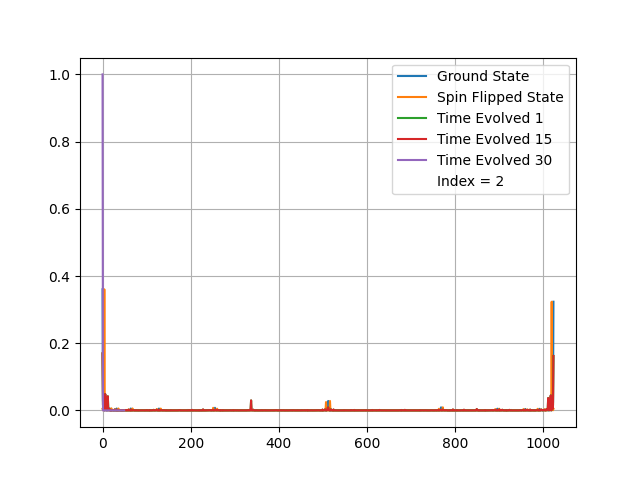

In [39]:
plt.close('all')
fig = plt.figure()

plt.plot(range(len(psi)),psi**2,label = 'Ground State')
plt.plot(range(len(psi)),psi_f**2,label = 'Spin Flipped State')

for i in np.linspace(1,t_total/t_step,3,dtype=int):
    plt.plot(range(len(psi_t[i])),np.conj(psi_t[i])*psi_t[i],label = f"Time Evolved {i}")


plt.plot([],[],alpha = 0, label = f'Index = {index}')
plt.legend()
plt.grid()
plt.show()

In [10]:
'''
p(Krylov Space Dimension) - L = 20
A-phi (20, 256, 1)
H - Hk (20, 20)
complete hamiltonian(curvy H) - H (256, 256)
Eigenvectors of Hk- gsk_vec (20, 20)

Get ground state of hamiltonian
We have lancos basis (psi) -> as coeff of original basis

Hamilotonal -> ground state in lancoz

Consider a LXL matrix T which we diagonalise -> get eigenstates = (V) which are -> entries are basis vectors of krylov
(this gives the weightage of each lancoz vectors)

GS in full H->  T-matrix

Cprofile
'''

'\np(Krylov Space Dimension) - L = 20\nA-phi (20, 256, 1)\nH - Hk (20, 20)\ncomplete hamiltonian(curvy H) - H (256, 256)\nEigenvectors of Hk- gsk_vec (20, 20)\n\nGet ground state of hamiltonian\nWe have lancos basis (psi) -> as coeff of original basis\n\nHamilotonal -> ground state in lancoz\n\nConsider a LXL matrix T which we diagonalise -> get eigenstates = (V) which are -> entries are basis vectors of krylov\n(this gives the weightage of each lancoz vectors)\n\nGS in full H->  T-matrix\n\nCprofile\n'

In [11]:
'''
Lanczos basis ie. each of the phi is the weightage of the origina


psi = matrix of krylov basis vectors * krylov ground state vector
'''

'\nLanczos basis ie. each of the phi is the weightage of the origina\n\n\npsi = matrix of krylov basis vectors * krylov ground state vector\n'